In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

SEEDS = [5,26,47,76,92]

ENVIRONMENT_NAME = "MOSuperMarioBrosZeroShot-v2" # CHANGE THIS TO THE NAME OF THE ENVIRONMENT
METRIC = "NHGR" # CHANGE THIS TO THE DESIRED METRIC

In [2]:
from helpers.utils import ENVIRONMENTS_MAP, ENVIRONMENT_TO_ALGORITHMS_MAP, \
ALGORITHMS_NAME_MAP, ALGORITHMS_COLOR_MAP

# Get the algorithms for the type of environment (e.g. discrete, continuous, pixel)
ALGORITHMS = ENVIRONMENT_TO_ALGORITHMS_MAP[ENVIRONMENT_NAME]
# Get the evaluation environemnts for the domain
ENVIRONMENTS = ENVIRONMENTS_MAP[ENVIRONMENT_NAME]
ENVIRONMENTS.remove("MOSuperMarioBros-3-3-v2")

In [3]:
def load_scores(env_id, algorithms, seeds, metric):
    scores = {}
    for algorithm in algorithms:
        algorithm_name = ALGORITHMS_NAME_MAP[algorithm]
        scores[algorithm_name] = {}
        for env in ENVIRONMENTS:
            for seed in seeds:
                df = pd.read_csv(f"data/scores/{env_id}/{algorithm}/seed_{seed}.csv")
                metric_values = df[metric + f"/{env}"].values
                scores[algorithm_name].setdefault(env, []).extend(metric_values)
    return scores

def convert_to_matrix(score_dict):
    keys = sorted(list(score_dict.keys()))
    return np.stack([score_dict[k] for k in keys], axis=1)

In [4]:
scores_dict = load_scores(ENVIRONMENT_NAME, ALGORITHMS, SEEDS, METRIC)
for algo in scores_dict.keys():
    scores_dict[algo] = convert_to_matrix(scores_dict[algo])
scores_dict

{'GPI-LS': array([[0.05687253, 0.02615802, 0.05498746, 0.37977766, 0.18191769,
         0.55830776, 0.06280349],
        [0.02174127, 0.07632783, 0.2669289 , 0.24973312, 0.1941751 ,
         0.54079246, 0.04742744],
        [0.03110362, 0.31992702, 0.33253145, 0.31447359, 0.31140018,
         0.58857987, 0.15223565],
        [0.13649356, 0.16412292, 0.09353872, 0.24780468, 0.179329  ,
         0.39142186, 0.06811517],
        [0.01257725, 0.12650413, 0.07780542, 0.28182055, 0.18710255,
         0.48399523, 0.04247787]]),
 'Envelope': array([[0.00435245, 0.02745176, 0.00055247, 0.0019438 , 0.04267483,
         0.1623376 , 0.0610339 ],
        [0.00895523, 0.00694789, 0.03667339, 0.05238844, 0.0287747 ,
         0.29468505, 0.01948788],
        [0.00541607, 0.01201989, 0.26554793, 0.03232093, 0.00648558,
         0.03579514, 0.03242769],
        [0.02703787, 0.00736303, 0.0696274 , 0.00539768, 0.00835465,
         0.08303016, 0.03180176],
        [0.01856776, 0.01675503, 0.01630242, 0.00

Best algorithm: GPI-LS


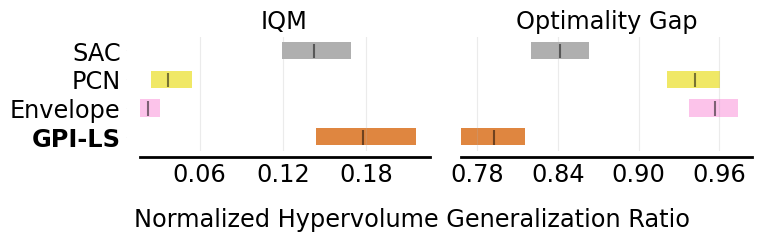

Aggregate scores: {'GPI-LS': array([0.17750696, 0.79253397]), 'Envelope': array([0.02307631, 0.95696802]), 'PCN': array([0.03737494, 0.94156877]), 'SAC': array([0.1420264 , 0.84148709])}
Aggregate interval estimates: {'GPI-LS': array([[0.14338368, 0.76830809],
       [0.21551229, 0.81558729]]), 'Envelope': array([[0.01666874, 0.93758451],
       [0.03125862, 0.97363986]]), 'PCN': array([[0.02517141, 0.92108291],
       [0.05428373, 0.96025376]]), 'SAC': array([[0.11936487, 0.81971631],
       [0.16858048, 0.86307485]])}


In [5]:
from rliable import library as rly
from rliable import metrics
from helpers.rliable import plot_interval_estimates

IQM = lambda x: metrics.aggregate_iqm(x)                    # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0)     # Optimality Gap

aggregate_func = lambda x: np.array([IQM(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    scores_dict, aggregate_func, reps=50000)

fig, axes = plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['IQM', 'Optimality Gap'],
    algorithms=list(scores_dict.keys()),
    colors=ALGORITHMS_COLOR_MAP,
    xlabel_y_coordinate=-0.4,
    bold_best=True, # Bold the best algorithm
    # subfigure_width=3.6,
    # max_ticks=3,
    xlabel='Normalized Hypervolume Generalization Ratio')

# Change svg to png/jpg if you want to save the figure in a different bitmap format
plt.savefig(f'images/{ENVIRONMENT_NAME}_{METRIC}_IQM_OG.svg', format='svg', bbox_inches='tight')
plt.show()

print("Aggregate scores:", aggregate_scores)
print("Aggregate interval estimates:", aggregate_interval_estimates)

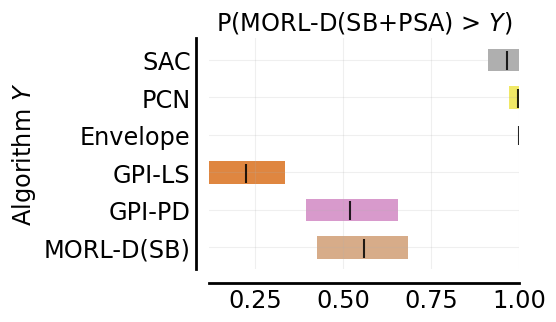

In [23]:
from matplotlib.ticker import MaxNLocator
from rliable import plot_utils

all_pairs = {}
best_algo = 'MORL-D(SB+PSA)'
for alg_y in (scores_dict.keys()):
  if alg_y == best_algo:
    continue
  pair_name = f'{best_algo},{alg_y}'
  all_pairs[pair_name] = (scores_dict[best_algo], scores_dict[alg_y]) 

probabilities, probability_cis = {}, {}
probabilities, probability_cis = rly.get_interval_estimates(all_pairs, metrics.probability_of_improvement, reps=2000)

fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
  _, alg1 = alg_pair.split(',')
  algorithm_labels.append(alg1)
  (l, u) = probability_cis[alg_pair]
  ax.barh(y=i, width=u-l, height=h, left=l, color=ALGORITHMS_COLOR_MAP[alg1], alpha=0.75)
  ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16), color='k', alpha=0.85)
ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)


ax.set_title(fr'P({best_algo} > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
fig.subplots_adjust(wspace=0.25, hspace=0.45)

plt.savefig(f'images/{ENVIRONMENT_NAME}_PROB_IMPROVEMENT.png', format='png', bbox_inches='tight')
plt.show()